In [1]:
# # Jupyter Notebook'u tam sayfa yapmak için...
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [ ]:
!pip install missingno
!pip install mlxtend
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import mlxtend
import warnings
import datetime as dt
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0
!pip install --upgrade pandas seaborn
!pip install ipywidgets

from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 400)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [248]:
df = pd.read_csv("diabetes.csv")

In [250]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [252]:
def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat


In [254]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [256]:
for column in df.columns:
    zero_count = (df[column] == 0).sum()
    if zero_count > 0:
        print(f"{column}: {zero_count} adet 0 değeri")
        print("\n ############# \n")

Pregnancies: 111 adet 0 değeri

 ############# 

Glucose: 5 adet 0 değeri

 ############# 

BloodPressure: 35 adet 0 değeri

 ############# 

SkinThickness: 227 adet 0 değeri

 ############# 

Insulin: 374 adet 0 değeri

 ############# 

BMI: 11 adet 0 değeri

 ############# 

Outcome: 500 adet 0 değeri

 ############# 



In [258]:
for column in df.columns:
    zero_count = (df[column] == 0).sum()/df.shape[0]
    if zero_count > 0:
        print(f"{column}: {zero_count:.2%} oranında 0 değeri")
        print("\n ############# \n")

Pregnancies: 14.45% oranında 0 değeri

 ############# 

Glucose: 0.65% oranında 0 değeri

 ############# 

BloodPressure: 4.56% oranında 0 değeri

 ############# 

SkinThickness: 29.56% oranında 0 değeri

 ############# 

Insulin: 48.70% oranında 0 değeri

 ############# 

BMI: 1.43% oranında 0 değeri

 ############# 

Outcome: 65.10% oranında 0 değeri

 ############# 



In [260]:
#data içerisinde 0 olan ama aslında null değerleri nan olarak değiştirme
zero_columns= [col for col in df.columns if (df[col].min() == 0 and col not in ['Pregnancies','Outcome'])]

In [262]:
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [264]:
for col in zero_columns:
    df[col] = df[col].replace(0, np.nan)

In [266]:
df.shape

(768, 9)

In [268]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [270]:
# Her satırdaki boş değer sayısı
df['Eksik_Deger_Sayisi'] = df.isnull().sum(axis=1)
print(df.sort_values('Eksik_Deger_Sayisi', ascending=False).head(10))

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome  Eksik_Deger_Sayisi
60             2    84.00            NaN            NaN      NaN   NaN                      0.30   21        0                   4
81             2    74.00            NaN            NaN      NaN   NaN                      0.10   22        0                   4
522            6   114.00            NaN            NaN      NaN   NaN                      0.19   26        0                   4
494            3    80.00            NaN            NaN      NaN   NaN                      0.17   22        0                   4
49             7   105.00            NaN            NaN      NaN   NaN                      0.30   24        0                   4
706           10   115.00            NaN            NaN      NaN   NaN                      0.26   30        1                   4
426            0    94.00            NaN            NaN      NaN   NaN             

In [272]:
#tahmin düzeyi zorlaştığı ve çok fazla olmadığı için 4 farklı kolonda null verisi olan 7 satırı sildim
df = df[df.isnull().sum(axis=1) != 4]

In [274]:
df.drop("Eksik_Deger_Sayisi", axis=1, inplace=True)

In [276]:
df.shape

(761, 9)

In [278]:
#knn missing v
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.00,148.00,72.00,35.00,334.20,33.60,0.63,50.00,1.00
1,1.00,85.00,66.00,29.00,56.20,26.60,0.35,31.00,0.00
2,8.00,183.00,64.00,32.20,238.00,23.30,0.67,32.00,1.00
3,1.00,89.00,66.00,23.00,94.00,28.10,0.17,21.00,0.00
4,0.00,137.00,40.00,35.00,168.00,43.10,2.29,33.00,1.00


In [280]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [282]:
# BMI ile Insulin feture oluşturma
df["NEW_BMI*Insulin"] = df['BMI']*df['Insulin']

In [284]:
# outlier eşiğini belirliyoruz
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [286]:
for col in num_cols:
    print(col, outlier_thresholds(df, col))

Pregnancies (-6.499999999999998, 13.499999999999996)
Glucose (38.5, 202.5)
BloodPressure (39.99999999999998, 104.00000000000003)
SkinThickness (5.0, 53.0)
Insulin (-60.000000000000085, 340.00000000000006)
BMI (13.849999999999998, 50.25)
DiabetesPedigreeFunction (-0.3335, 1.2065000000000001)
Age (-1.5, 66.5)


In [288]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[col_name][(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)]
    return outliers.any() 

In [290]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [292]:
# trashold değerlerine baskılama fonksiyonu
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [294]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [296]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [298]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_BMI*Insulin
0,6.00,148.00,72.00,35.00,334.20,33.60,0.63,50.00,1.00,11229.12
1,1.00,85.00,66.00,29.00,56.20,26.60,0.35,31.00,0.00,1494.92
2,8.00,183.00,64.00,32.20,238.00,23.30,0.67,32.00,1.00,5545.40
3,1.00,89.00,66.00,23.00,94.00,28.10,0.17,21.00,0.00,2641.40
4,0.00,137.00,40.00,35.00,168.00,43.10,1.21,33.00,1.00,7240.80


In [300]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Özellikleri (X) ve hedef değişkeni (y) ayır
A = df.drop("Outcome", axis=1)
B = df["Outcome"]

# 2. SMOTE nesnesini oluştur
smote = SMOTE(random_state=42)

# 3. SMOTE uygulayarak veriyi dengele
X_resampled, y_resampled = smote.fit_resample(A, B)

# 4. Yeni dengelenmiş veri çerçevesini oluştur
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=A.columns),
                           pd.DataFrame(y_resampled, columns=["Outcome"])], axis=1)

# 5. Sınıf dağılımını kontrol et
print("Orijinal veri dağılımı:", Counter(B))
print("SMOTE sonrası veri dağılımı:", Counter(y_resampled))

# İlk birkaç satırı göster
df_resampled.head()

Orijinal veri dağılımı: Counter({0.0: 494, 1.0: 267})
SMOTE sonrası veri dağılımı: Counter({1.0: 494, 0.0: 494})


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_BMI*Insulin,Outcome
0,6.00,148.00,72.00,35.00,334.20,33.60,0.63,50.00,11229.12,1.00
1,1.00,85.00,66.00,29.00,56.20,26.60,0.35,31.00,1494.92,0.00
2,8.00,183.00,64.00,32.20,238.00,23.30,0.67,32.00,5545.40,1.00
3,1.00,89.00,66.00,23.00,94.00,28.10,0.17,21.00,2641.40,0.00
4,0.00,137.00,40.00,35.00,168.00,43.10,1.21,33.00,7240.80,1.00


In [302]:
X = df_resampled.drop('Outcome', axis=1)
y = df_resampled['Outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print("X_test: ", X_test.shape),
print ("y_test: ", y_test.shape)

X_train:  (790, 9)
y_train:  (790,)
X_test:  (198, 9)
y_test:  (198,)


In [304]:
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import recall_score

# Recall metriği için özel fonksiyon
def recall(y_true, y_pred):
    return recall_score(y_true, y_pred)

# LazyClassifier recall'u da ölçsün
clf = LazyClassifier(ignore_warnings=True, custom_metric=recall)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)


print(models)
model = LGBMClassifier(verbosity=-1, verbose=-1)

  0%|          | 0/29 [00:00<?, ?it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  recall  Time Taken
Model                                                                                            
LGBMClassifier                     0.86               0.86     0.86      0.86    0.87        0.04
SVC                                0.85               0.85     0.85      0.85    0.82        0.02
NuSVC                              0.85               0.85     0.85      0.85    0.84        0.02
LabelSpreading                     0.84               0.84     0.84      0.84    0.86        0.02
LabelPropagation                   0.84               0.84     0.84      0.84    0.86        0.02
ExtraTreesClassifier               0.84               0.84     0.84      0.84    0.84        0.06
XGBClassifier                      0.83               0.83     0.83      0.83    0.86        0.04
RandomForestClassifier             0.83               0.83     0.83      0.83    0.84        0.15
KNeighborsClassifier

🌲 ExtraTreesClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       101
         1.0       0.84      0.84      0.84        97

    accuracy                           0.84       198
   macro avg       0.84      0.84      0.84       198
weighted avg       0.84      0.84      0.84       198



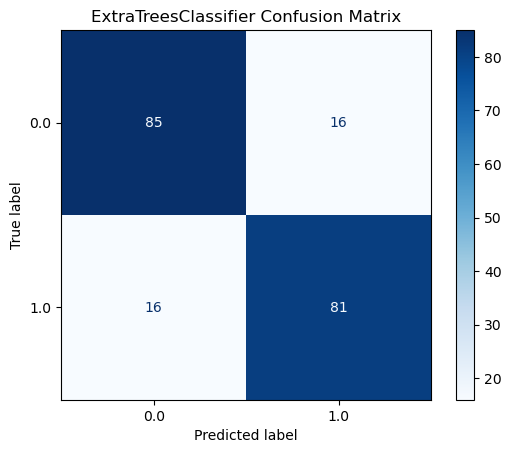

In [306]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Modeli tanımla ve eğit
et_model = ExtraTreesClassifier(random_state=42)
et_model.fit(X_train, y_train)

# Tahmin yap
y_pred_et = et_model.predict(X_test)

# Sınıflandırma raporu
print("🌲 ExtraTreesClassifier Classification Report:")
print(classification_report(y_test, y_pred_et, digits=2))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_et, cmap="Blues", values_format="d")
plt.title("ExtraTreesClassifier Confusion Matrix")
plt.show()

In [308]:
from sklearn.metrics import classification_report
rand_score_test=et_model.score(X_test, y_test)
rand_score_train=et_model.score(X_train, y_train)


print("accuracy score test :",rand_score_test)
print("accuracy score train:",rand_score_train)

accuracy score test : 0.8383838383838383
accuracy score train: 1.0


🌳 RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       101
         1.0       0.82      0.84      0.83        97

    accuracy                           0.83       198
   macro avg       0.83      0.83      0.83       198
weighted avg       0.83      0.83      0.83       198



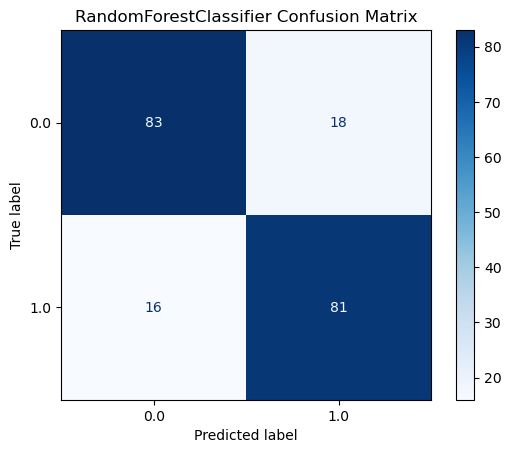

In [364]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. RandomForestClassifier modelini oluştur
rf_model = RandomForestClassifier(random_state=42)

# 2. Modeli eğitim verisiyle eğit
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)

# 3. Test verisi ile tahmin yap
y_pred_rf = rf_model.predict(X_test)

# 4. Sınıflandırma raporunu yazdır
print("🌳 RandomForestClassifier Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=2))

# 5. Confusion Matrix'i çiz
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap="Blues", values_format="d"
)
plt.title("RandomForestClassifier Confusion Matrix")
plt.show()

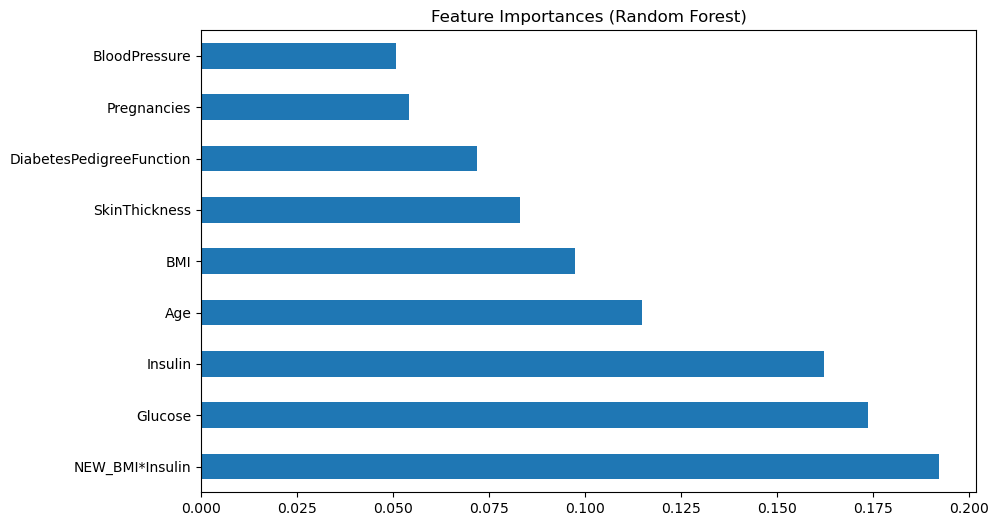

In [312]:
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind="barh", figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.show()

In [314]:
from sklearn.metrics import classification_report
rand_score_test=rf_model.score(X_test, y_test)
rand_score_train=rf_model.score(X_train, y_train)


print("accuracy score test :",rand_score_test)
print("accuracy score train:",rand_score_train)

accuracy score test : 0.8282828282828283
accuracy score train: 1.0


In [316]:
from sklearn.metrics import recall_score

# Eğitim ve test verisi için tahminler
y_pred_rf = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Recall skorlarını hesapla (ikili sınıflandırma varsayılarak)
recall_test = recall_score(y_test, y_pred_rf)
recall_train = recall_score(y_train, y_pred_train)

print("Recall (Test):", recall_test)
print("Recall (Train):", recall_train)

Recall (Test): 0.8350515463917526
Recall (Train): 1.0


In [318]:
# İlk ağacın derinliğini göster
print("İlk karar ağacının derinliği:", rf_model.estimators_[0].get_depth())

İlk karar ağacının derinliği: 15


In [320]:
depths = [est.get_depth() for est in rf_model.estimators_]
print("Ortalama derinlik:", sum(depths)/len(depths))

Ortalama derinlik: 14.39


🌳 RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       101
         1.0       0.78      0.84      0.81        97

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198



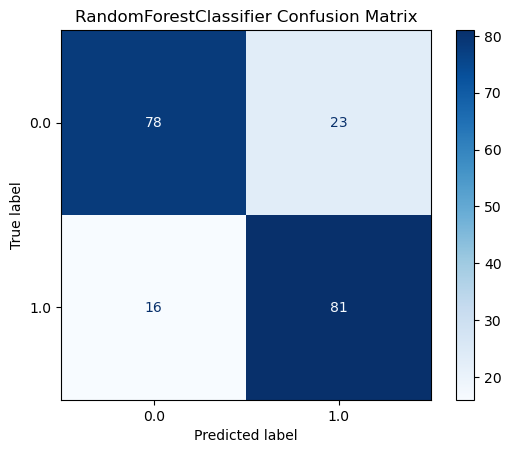

In [322]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. RandomForestClassifier modelini oluştur max depth 5
rf_model = RandomForestClassifier( max_depth=5, random_state=42)

# 2. Modeli eğitim verisiyle eğit
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)

# 3. Test verisi ile tahmin yap
y_pred_rf = rf_model.predict(X_test)

# 4. Sınıflandırma raporunu yazdır
print("🌳 RandomForestClassifier Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=2))

# 5. Confusion Matrix'i çiz
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap="Blues", values_format="d"
)
plt.title("RandomForestClassifier Confusion Matrix")
plt.show()

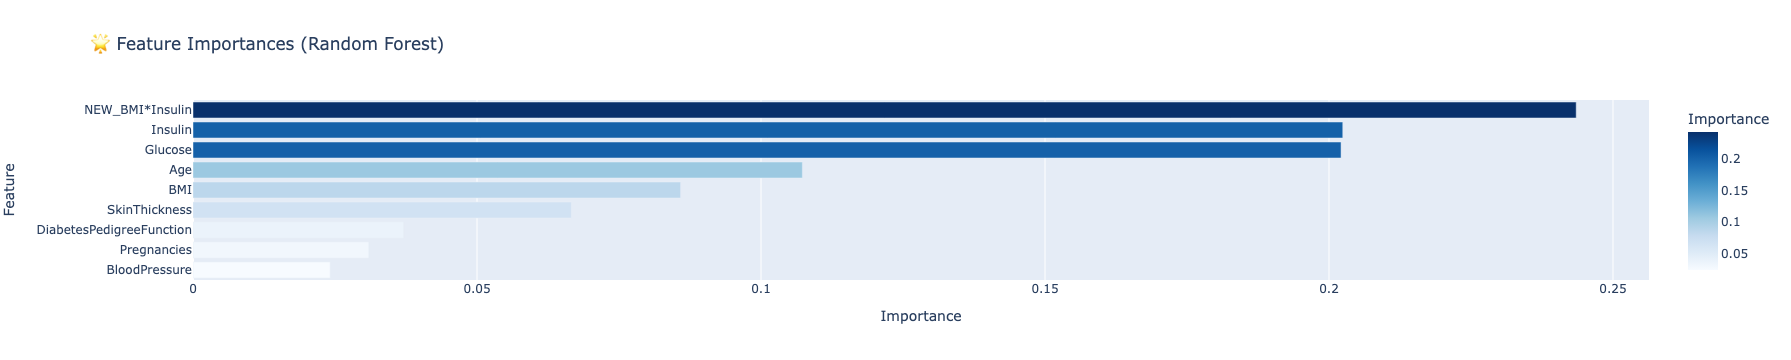

In [324]:
import plotly.express as px
import pandas as pd

# Veri hazırla
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Etkileşimli yatay bar grafiği
fig = px.bar(
    feat_imp_df, 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    color='Importance',
    color_continuous_scale='Blues',  # Mavi tonları
    title='🌟 Feature Importances (Random Forest)'
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [326]:
# İlk ağacın derinliğini göster
print("İlk karar ağacının derinliği:", rf_model.estimators_[0].get_depth())

İlk karar ağacının derinliği: 5


In [328]:
depths = [est.get_depth() for est in rf_model.estimators_]
print("Ortalama derinlik:", sum(depths)/len(depths))

Ortalama derinlik: 5.0


In [330]:
from sklearn.metrics import classification_report
rand_score_test=rf_model.score(X_test, y_test)
rand_score_train=rf_model.score(X_train, y_train)


print("Accuracy Score (Test) :",rand_score_test)
print("Accuracy Score (Train):",rand_score_train)

Accuracy Score (Test) : 0.803030303030303
Accuracy Score (Train): 0.8974683544303798


In [332]:
from sklearn.metrics import recall_score

# Eğitim ve test verisi için tahminler
y_pred_rf = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Recall skorlarını hesapla (ikili sınıflandırma varsayılarak)
recall_test = recall_score(y_test, y_pred_rf)
recall_train = recall_score(y_train, y_pred_train)

print("Recall (Test):", recall_test)
print("Recall (Train):", recall_train)

Recall (Test): 0.8350515463917526
Recall (Train): 0.9496221662468514


In [334]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Modeli oluştur
rf_model = RandomForestClassifier(max_depth=5, random_state=42)

# 5-fold cross-validation ile accuracy ölç
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Sonuçları yazdır
print("Cross-validation accuracy scores:", cv_scores)
print("Ortalama accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [0.77777778 0.75757576 0.83838384 0.84771574 0.83756345]
Ortalama accuracy: 0.8118033123109264


In [336]:

# Recall için cross-validation
recall_scores = cross_val_score(rf_model, X, y, cv=5, scoring='recall')

# Sonuçları yazdır
print("Cross-validation recall scores:", recall_scores)
print("Ortalama recall:", recall_scores.mean())

Cross-validation recall scores: [0.84848485 0.78787879 0.86868687 0.92929293 0.89795918]
Ortalama recall: 0.8664605236033808


In [338]:
from sklearn.model_selection import GridSearchCV

In [340]:
rf_model = RandomForestClassifier(random_state=42)

rf_params = {"max_depth": [5,6],
             "max_features": [10, 15, 18],
             "min_samples_split": [2,10],
             "n_estimators": [100]} 

In [342]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [343]:
rf_best_grid.best_params_

{'max_depth': 6,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 100}

In [344]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=42).fit(X, y)

In [348]:
y_pred = rf_final.predict(X_test)

🌳 RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92       101
         1.0       0.88      0.97      0.92        97

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



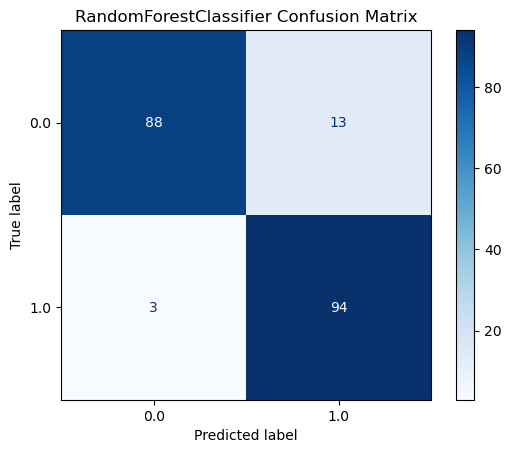

In [350]:
# 4. Sınıflandırma raporunu yazdır
print("🌳 RandomForestClassifier Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

# 5. Confusion Matrix'i çiz
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.title("RandomForestClassifier Confusion Matrix")
plt.show()

In [352]:
#from sklearn.metrics import classification_report
rand_score_test=rf_final.score(X_test, y_test)
rand_score_train=rf_final.score(X_train, y_train)


print("Accuracy Score (Test) :",rand_score_test)
print("Accuracy Score (Train):",rand_score_train)

Accuracy Score (Test) : 0.9191919191919192
Accuracy Score (Train): 0.9240506329113924


In [354]:
# Eğitim ve test verisi için tahminler
y_pred_test = rf_final.predict(X_test)
y_pred_train = rf_final.predict(X_train)

# Recall skorlarını hesapla (ikili sınıflandırma varsayılarak)
recall_test = recall_score(y_test, y_pred)
recall_train = recall_score(y_train, y_pred_train)

print("Recall (Test):", recall_test)
print("Recall (Train):", recall_train)

Recall (Test): 0.9690721649484536
Recall (Train): 0.9748110831234257


In [356]:
#from sklearn.ensemble import RandomForestClassifier

# 5-fold cross-validation ile accuracy ölç
cv_scores = cross_val_score(rf_final, X, y, cv=5, scoring='accuracy')

# Sonuçları yazdır
print("Cross-validation accuracy scores:", cv_scores)
print("Ortalama accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [0.78787879 0.77777778 0.83333333 0.86294416 0.88324873]
Ortalama accuracy: 0.8290365584781829


In [358]:
# Recall için cross-validation
recall_scores = cross_val_score(rf_model, X, y, cv=5, scoring='recall')

# Sonuçları yazdır
print("Cross-validation recall scores:", recall_scores)
print("Ortalama recall:", recall_scores.mean())

Cross-validation recall scores: [0.83838384 0.82828283 0.87878788 0.94949495 0.94897959]
Ortalama recall: 0.8887858173572459


In [360]:
# Precision skorlarını hesapla
precision_test = precision_score(y_test, y_pred_test)
precision_train = precision_score(y_train, y_pred_train)

print("Precision (Test):", precision_test)
print("Precision (Train):", precision_train)

# Çapraz doğrulama ile precision hesaplama
precision_cv_scores = cross_val_score(rf_final, X, y, cv=5, scoring='precision')

print("\nCross-validation precision scores:", precision_cv_scores)
print("Ortalama precision:", precision_cv_scores.mean())

Precision (Test): 0.8785046728971962
Precision (Train): 0.88558352402746

Cross-validation precision scores: [0.76146789 0.75229358 0.80555556 0.81034483 0.83783784]
Ortalama precision: 0.7934999377739017


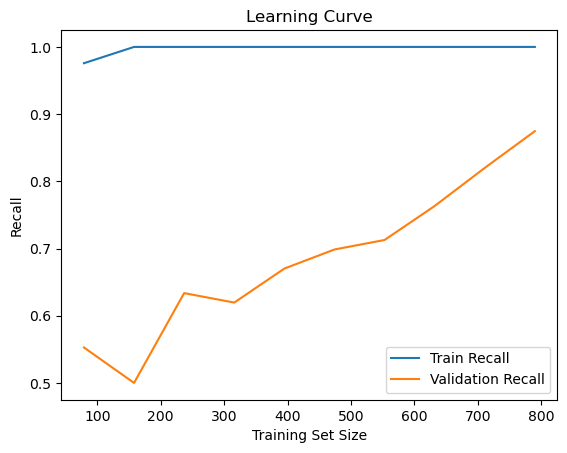

In [362]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='recall', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Recall')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Recall')
plt.xlabel('Training Set Size')
plt.ylabel('Recall')
plt.legend()
plt.title('Learning Curve')
plt.show()